In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost
import hyperopt
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


try:
    from jupyterthemes import jtplot
    jtplot.style()
except: pass
%pylab inline
# pylab.rcParams['figure.figsize']=(12, 8)

Populating the interactive namespace from numpy and matplotlib


## Import the data
Using heart disease data. Mixture of continuous and categorical variables. 
Every feature has already been encoded and the dataset is quite friendly without massaging.

In [2]:
df = pd.read_csv('./heart.csv')
display(df.head())
display(df.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [3]:
X = df.drop(columns=['target'])
y = df['target']

## Some light EDA

Just to get a quick feel for the data

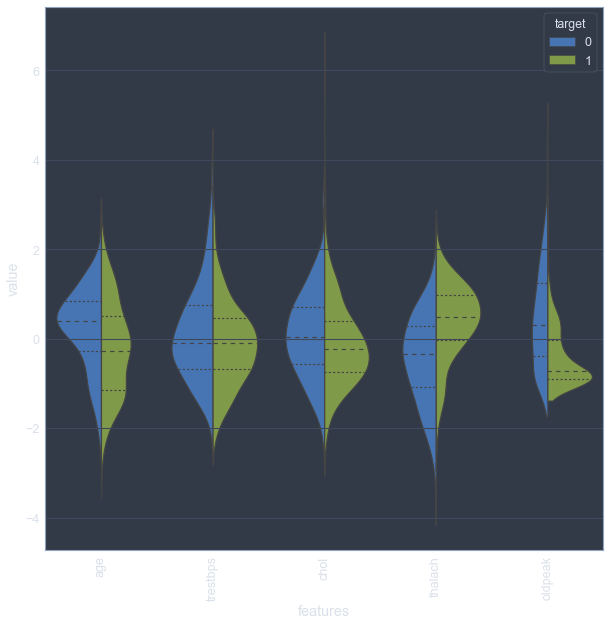

In [4]:
# Take a look at the difference in feature distribution across the dataset
data_dia = y
X_continuos = X[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
data_n_2 = (X_continuos - X_continuos.mean()) / (X_continuos.std())
data = pd.concat([y,data_n_2],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


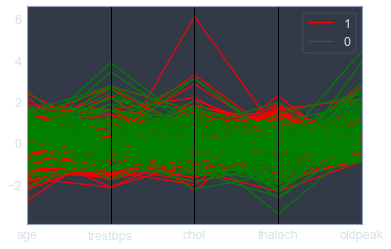

In [5]:
# plot parallel coordinates
from pandas.plotting import parallel_coordinates
data_pc = (X_continuos - X_continuos.mean()) / X_continuos.std()
pc = parallel_coordinates(data_pc.assign(y=y), 'y', color=('red', 'green'))

c:\users\breeves\appdata\local\continuum\miniconda3\envs\py3default\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


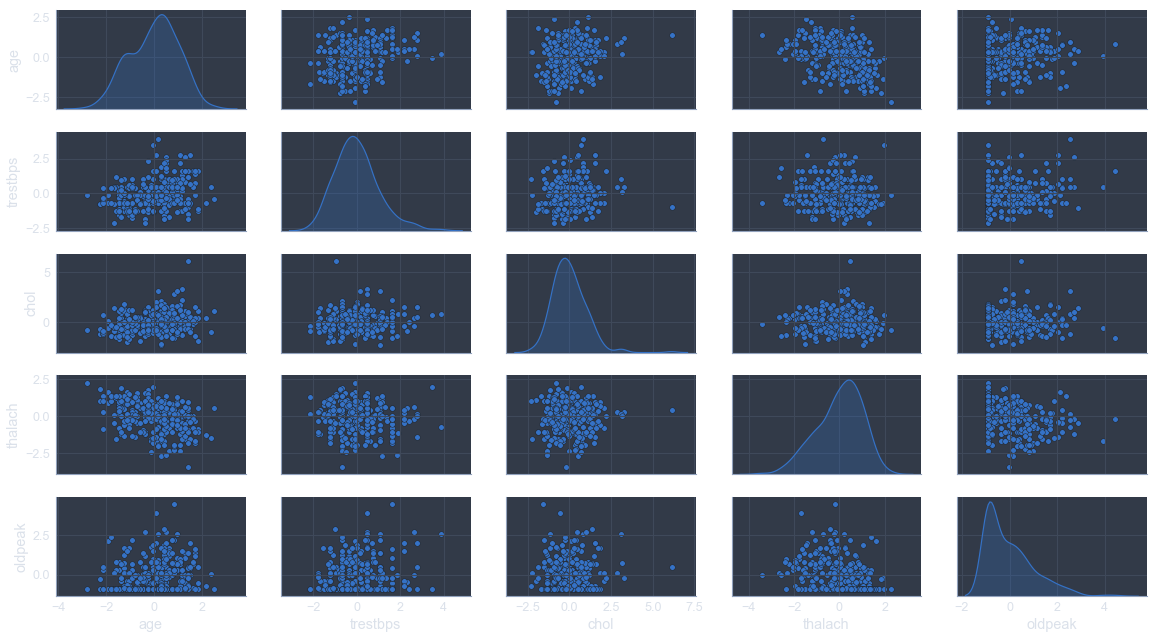

In [7]:
# Pair-wise Scatter Plots
pp = sns.pairplot(data_pc, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

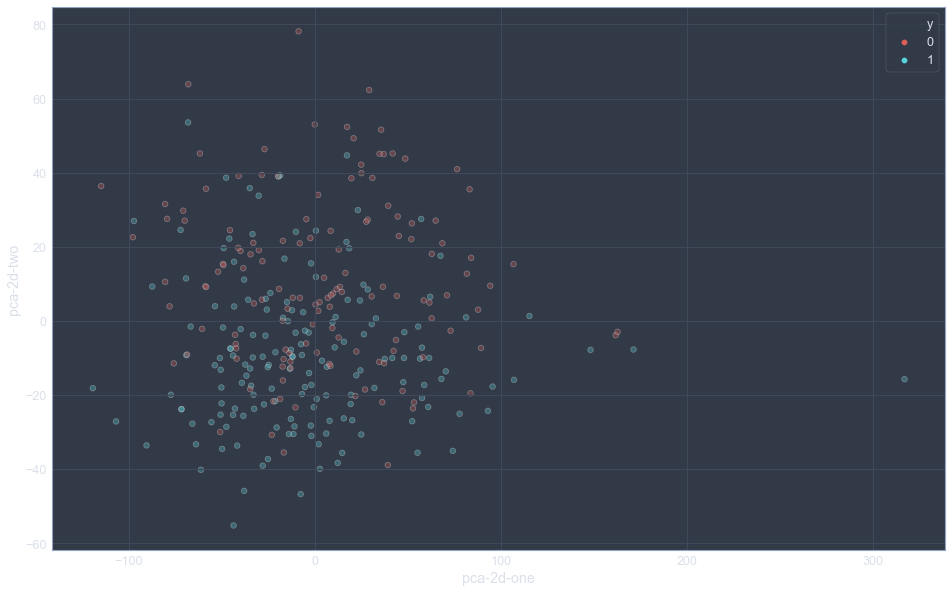

In [8]:
pca = PCA(n_components=2)
data_pca = pd.DataFrame(pca.fit_transform(X_continuos),
                        columns=['pca-2d-one', 'pca-2d-two'])
data_pca['y'] = y
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue="y",
    data=data_pca,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

In [9]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 303 samples in 0.001s...
[t-SNE] Computed neighbors for 303 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 303 / 303
[t-SNE] Mean sigma: 9.547481
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.667194
[t-SNE] KL divergence after 300 iterations: 0.559551


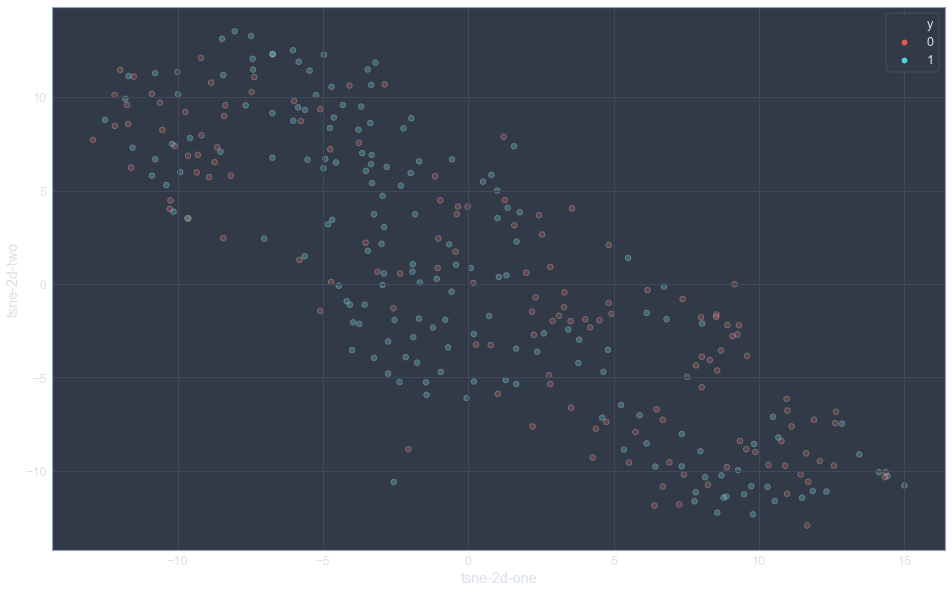

In [10]:
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['y'] = y
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

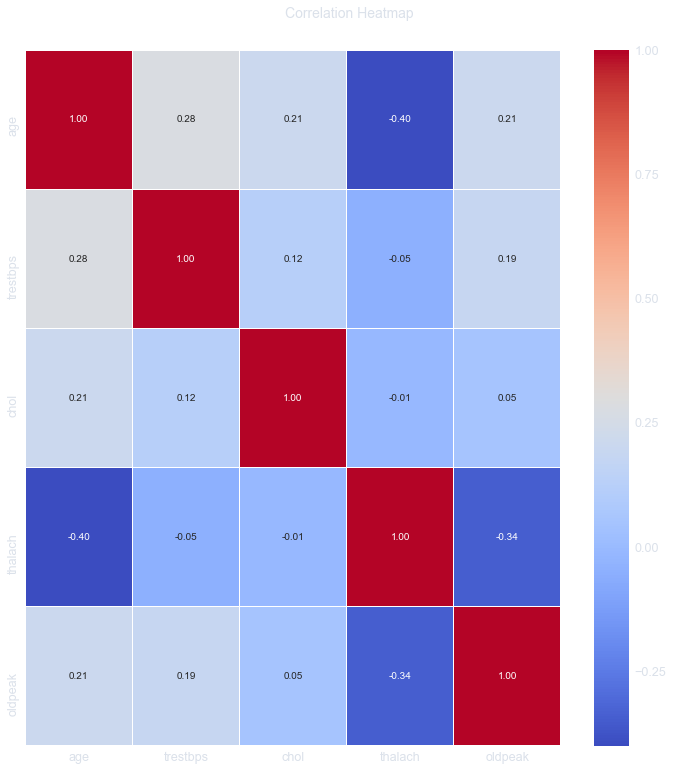

In [11]:
# Correlation Matrix Heatmap
corr = X_continuos.corr()
f,ax = plt.subplots(figsize=(12, 12))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)

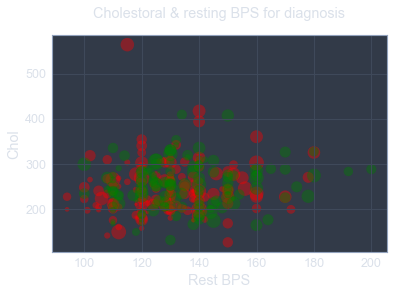

In [29]:
data_bubble = X_continuos.assign(y=y)
size =((data_bubble['age'] - 25) ** 2  / 10)
fill_colors = ['red' if d==1 else 'green'
               for d in list(data_bubble['y'])]


plt.scatter(data_bubble['trestbps'], data_bubble['chol'], s=size, 
            alpha=0.4, color=fill_colors)

plt.xlabel('Rest BPS')
plt.ylabel('Chol')
plt.title('Cholestoral & resting BPS for diagnosis',y=1.05);

## Set the initial baseline. 

In this example I'm just using a random forest to set a simple baseline and to use
for recursive feature elimination to select the top 5 features.

Dropping the number of features to decrease the accuracy a touch and allow you to experiment with optimization on a full feature dataset and a reduced feature dataset.

Accuracy is:  0.8241758241758241


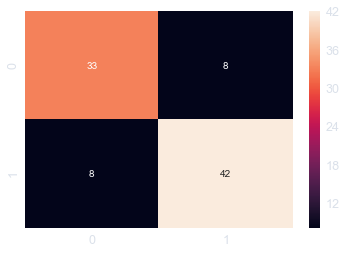

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43, n_estimators=100)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

Accuracy is:  0.7912087912087912


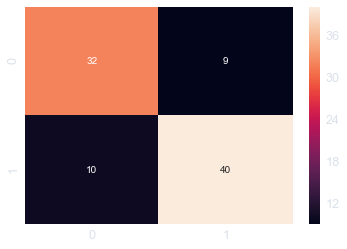

In [33]:
# Create the RFE and determine the reduced featureset baseline
clf_rf_3 = RandomForestClassifier(n_estimators=100, random_state=43)      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)

x_train_trim = x_train[x_train.columns[rfe.support_]]
x_test_trim = x_test[x_test.columns[rfe.support_]]

clf_rf_3.fit(x_train_trim, y_train)
ac = accuracy_score(y_test,clf_rf_3.predict(x_test_trim))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf_3.predict(x_test_trim))
sns.heatmap(cm,annot=True,fmt="d")

In [34]:
cols_for_opt = x_train_trim.columns
print(cols_for_opt)

Index(['cp', 'thalach', 'oldpeak', 'ca', 'thal'], dtype='object')


## Hyperparameter optimization

In [35]:
from xgboost import XGBClassifier
from hyperopt import hp, tpe, fmin, STATUS_OK
import hyperopt.pyll.stochastic
from hyperopt.pyll.stochastic import sample

Accuracy is:  0.7802197802197802


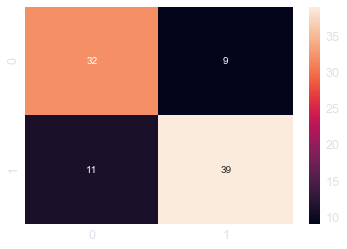

In [36]:
# create a new dataset using only the reduced features
X1 = X[cols_for_opt]
x_train, x_test, y_train, y_test = train_test_split(X1, y, 
                                                    test_size=0.3, random_state=42)

# using XGB here instead of random forest because I already had some code for it
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
ac = accuracy_score(y_test,xgb.predict(x_test_trim))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,xgb.predict(x_test_trim))
sns.heatmap(cm,annot=True,fmt="d")

In [37]:
# Define the search space OH BOI!
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', 
                               [{'boosting_type': 'gbdt', 
                                    'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                 {'boosting_type': 'dart', 
                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

def eval(estimator, x_train, x_test, y_train, y_test):
    estimator.fit(x_train, y_train)
    ac = accuracy_score(y_test,estimator.predict(x_test))
    f1 = f1_score(y_test,estimator.predict(x_test))
    return ac, f1

X_ = X1.copy()
y_ = y.copy()

# 5 fold cross validation for the "black box" optimization function. 
# Calls to this function are expensive and we want to minimimize the calls to it 
def objective(params):
    clf = XGBClassifier(**params)
    numFolds = 5
    folds = KFold(n_splits = numFolds, shuffle = True)
    results = np.zeros(len(X_))
    score = 0.0
    for train_index, test_index in folds.split(X_):
        X_train, X_test = X_.iloc[train_index,:], X_.iloc[test_index,:]
        y_train, y_test = y_.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        clf.fit(X_train, y_train)

        results[test_index] = clf.predict(X_test)
        score += f1_score(y_test, results[test_index])
    score /= numFolds
    loss = 1 - score
    return {'loss': loss, 'params': clf.get_params(),  'status': STATUS_OK}

In [38]:
# Sample from the full space
example = hyperopt.pyll.stochastic.sample(space)

# Dictionary get method with default
subsample = example['boosting_type'].get('subsample', 1.0)

# Assign top-level keys
example['boosting_type'] = example['boosting_type']['boosting_type']
example['subsample'] = subsample

example

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.7612935295382923,
 'learning_rate': 0.06698952346245164,
 'min_child_samples': 30.0,
 'num_leaves': 83.0,
 'reg_alpha': 0.9110548997920997,
 'reg_lambda': 0.6952436053195679,
 'subsample_for_bin': 160000.0,
 'subsample': 0.7751364739776574}

In [ ]:
# get a list of estimators with different parameter settings
n_max_param_combinations = 100
random_run_log = []

# take a random sample from the param distribution, calculate the objective and
# append to the run log
for i in range(n_max_param_combinations):
    param_dist = hyperopt.pyll.stochastic.sample(space)
    obj = objective(param_dist)
    print(obj['loss'])
    random_run_log.append(obj)

0.16455243681050136
0.1728583414884508
0.16739325661658488
0.18775408225305623
0.17372405372405364
0.15820314567440996
0.15745972692354915
0.16418432761359902
0.1408259313309509
0.15468017870763862
0.15710873524091917
0.17112324160782078
0.17360564614801888
0.1701638022427001
0.17052222158192298
0.1718835619871667
0.15166634025329684
0.17880578626076038
0.19794484734440254


In [40]:
from hyperopt import Trials
# HACK workaround
from hyperopt import base
base.have_bson = False
# END HACK workaround

# Keep track of results
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials,
            max_evals = n_max_param_combinations, rstate = np.random.RandomState(50))

100%|██████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.74it/s, best loss: 0.14445086785402117]


In [41]:
best

{'boosting_type': 1,
 'class_weight': 0,
 'colsample_by_tree': 0.6673076386901536,
 'dart_subsample': 0.9985285847190133,
 'learning_rate': 0.040118914534607024,
 'min_child_samples': 475.0,
 'num_leaves': 70.0,
 'reg_alpha': 0.8695100073452218,
 'reg_lambda': 0.44076667329472063,
 'subsample_for_bin': 160000.0}

## Compare bayesian vs random

Some charts showing the difference between the parameters selected from bayesian optimization and the parameters selected from random search

In [45]:
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
random_trials_results = sorted(random_run_log, key = lambda x: x['loss'])

In [46]:
df_r=pd.DataFrame(random_trials_results)
df_b = pd.DataFrame(bayes_trials_results)
df_random = pd.concat([df_r.drop(['params'], axis=1), 
           df_r['params'].apply(pd.Series)], axis=1)
df_random['method'] = 'random'

df_bayes = pd.concat([df_b.drop(['params'], axis=1), 
           df_b['params'].apply(pd.Series)], axis=1)
df_bayes['method'] = 'bayes'

df_params = pd.concat([df_bayes, df_random], ignore_index=True)
df_params

,loss,status,base_score,booster,colsample_bylevel,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,...,scale_pos_weight,seed,silent,subsample,boosting_type,class_weight,min_child_samples,num_leaves,subsample_for_bin,method
0,0.144451,ok,0.5,gbtree,1,0.667308,0,0.040119,0,3,...,1,None,True,1,"{'boosting_type': 'dart', 'subsample': 0.99852...",None,475.0,70.0,160000.0,bayes
1,0.146715,ok,0.5,gbtree,1,0.732679,0,0.017532,0,3,...,1,None,True,1,"{'boosting_type': 'gbdt', 'subsample': 0.51405...",balanced,420.0,34.0,220000.0,bayes
2,0.147570,ok,0.5,gbtree,1,0.813836,0,0.010162,0,3,...,1,None,True,1,{'boosting_type': 'goss'},balanced,375.0,146.0,260000.0,bayes
3,0.148293,ok,0.5,gbtree,1,0.804820,0,0.015276,0,3,...,1,None,True,1,"{'boosting_type': 'dart', 'subsample': 0.98383...",balanced,385.0,94.0,200000.0,bayes
4,0.148907,ok,0.5,gbtree,1,0.743686,0,0.040423,0,3,...,1,None,True,1,"{'boosting_type': 'gbdt', 'subsample': 0.72358...",None,395.0,126.0,200000.0,bayes
5,0.149566,ok,0.5,gbtree,1,0.853103,0,0.011768,0,3,...,1,None,True,1,{'boosting_type': 'goss'},None,110.0,114.0,40000.0,bayes
6,0.151003,ok,0.5,gbtree,1,0.622008,0,0.035652,0,3,...,1,None,True,1,"{'boosting_type': 'gbdt', 'subsample': 0.76618...",None,225.0,70.0,280000.0,bayes
7,0.152684,ok,0.5,gbtree,1,0.672021,0,0.013933,0,3,...,1,None,True,1,"{'boosting_type': 'gbdt', 'subsample': 0.78109...",balanced,335.0,50.0,80000.0,bayes
8,0.156035,ok,0.5,gbtree,1,0.665817,0,0.044026,0,3,...,1,None,True,1,"{'boosting_type': 'dart', 'subsample': 0.62240...",None,260.0,45.0,280000.0,bayes
9,0.156715,ok,0.5,gbtree,1,0.724876,0,0.023695,0,3,...,1,None,True,1,"{'boosting_type': 'gbdt', 'subsample': 0.50094...",None,450.0,36.0,220000.0,bayes


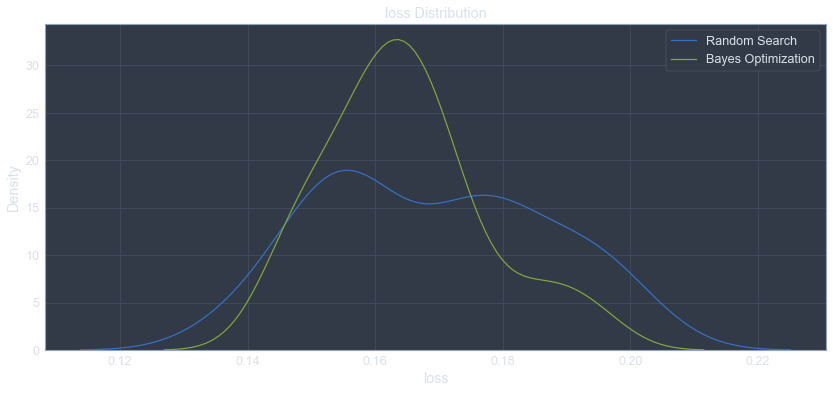

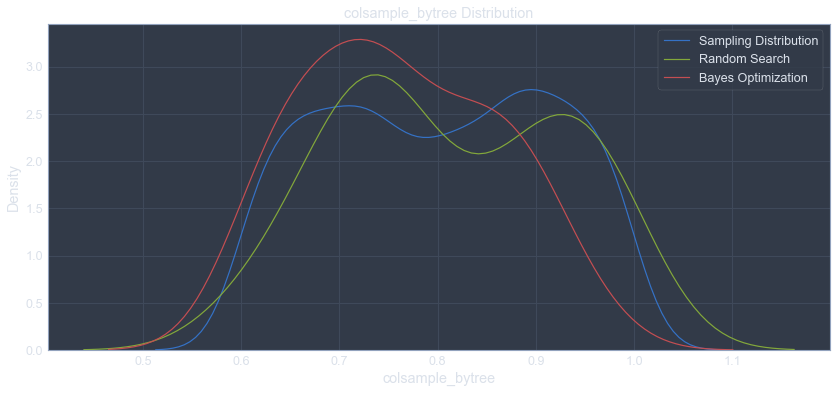

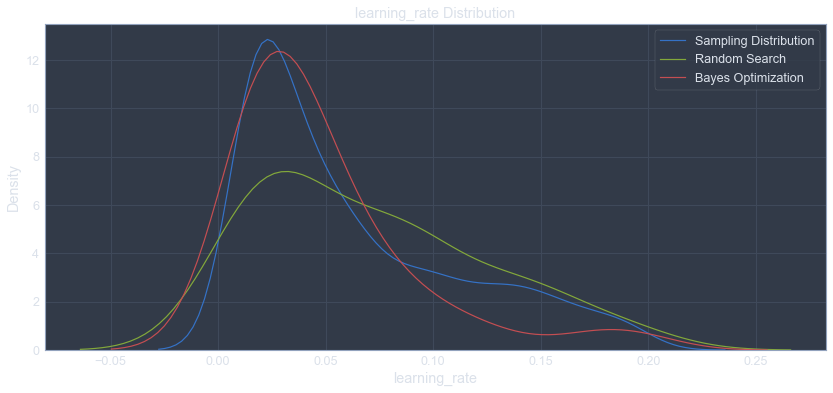

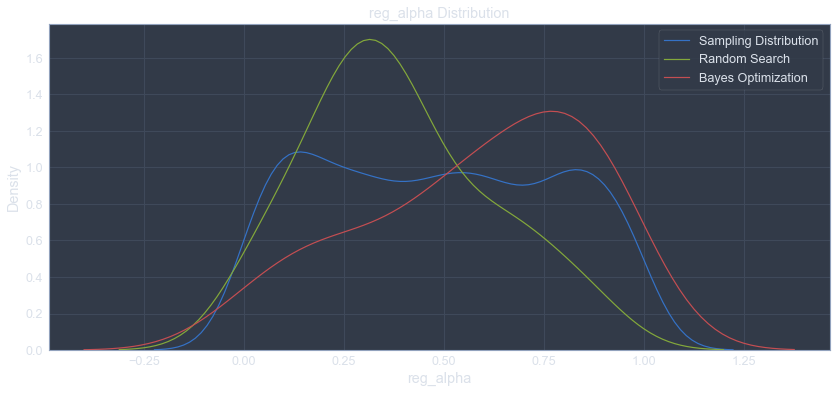

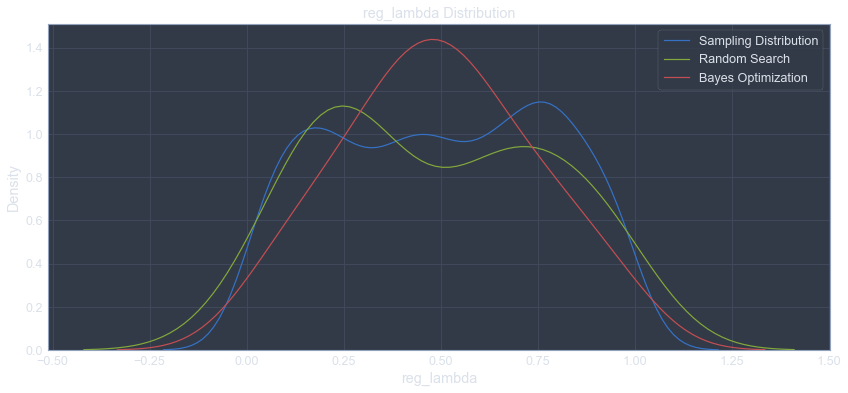

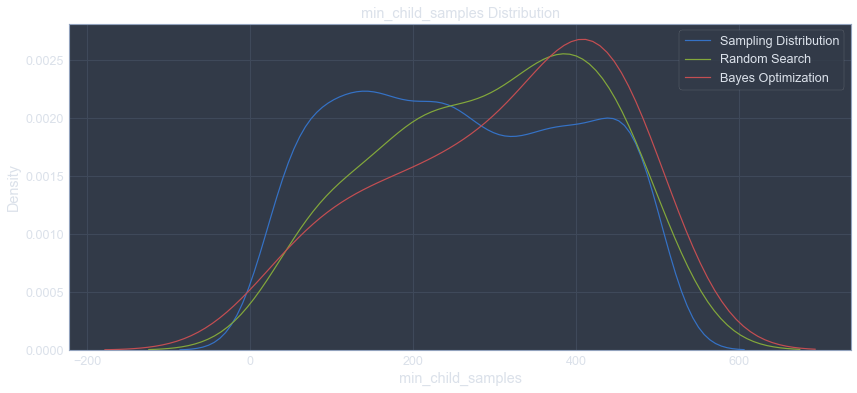

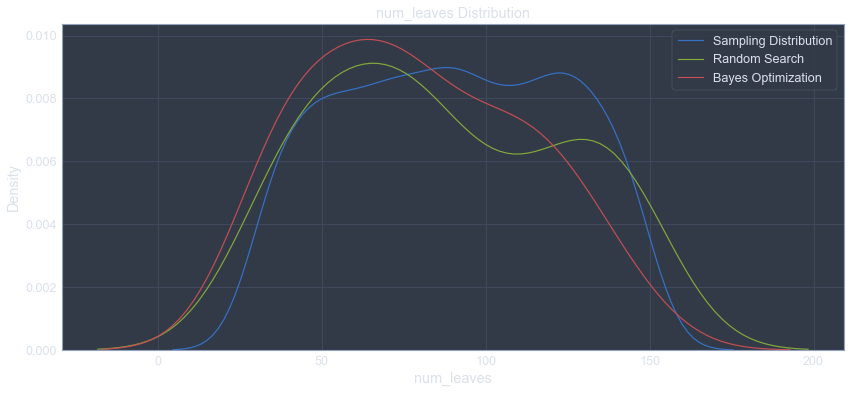

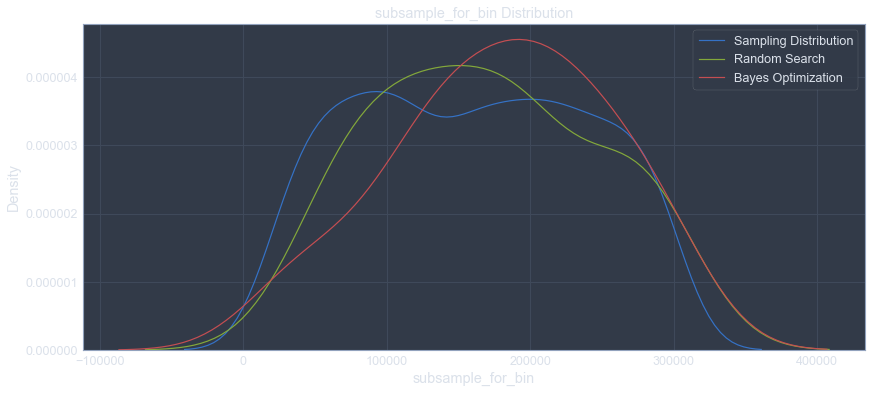

In [47]:
# Iterate through each hyperparameter
for i, hyper in enumerate(df_random.columns):
    try:
        if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
            plt.figure(figsize = (14, 6))
            # Plot the random search distribution and the bayes search distribution
            if hyper != 'loss':
                sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
            sns.kdeplot(df_random[hyper], label = 'Random Search')
            sns.kdeplot(df_bayes[hyper], label = 'Bayes Optimization')
            plt.legend(loc = 1)
            plt.title('{} Distribution'.format(hyper))
            plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
            plt.show()
    except:
        plt.close()
        pass